# 16. Decision Trees for Regression

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rhennig/EMA6938/blob/main/Notebooks/16.DecisionTreeRegression.ipynb)

Based on https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/.

In this notebook, we will use a decision tree model for regression of $({\bf X}, {\bf y})$ data to obtain a function $f({\bf x})$ that best models the labels $y$.

We had previously studied linear regression methods that provide a continuous model $f({\bf x})$.

In contrast, a ecision trees learns by splitting the training samples in a way such that the sum of squared residuals is minimized. It then predicts the output value by taking the average of all of the examples that fall into a certain leaf on the decision tree and using that as the output prediction.

To illustrate the behavior of decision trees for regression, we will fit a simple one-dimensional function to the same data set that we previously used for linear regression.

In [1]:
# Import the numpy, panda, sklearn, and matplotlib libraries
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

### Create a one-dimensional dataset for regression

In [2]:
# Generate a data set for machine learning
np.random.seed(seed=5)
x=np.linspace(0, 2, 300)
x=x+np.random.normal(0,.3,x.shape)
y=np.cos(x)+2*np.sin(x)+3*np.cos(x*2)+np.random.normal(0,1,x.shape)

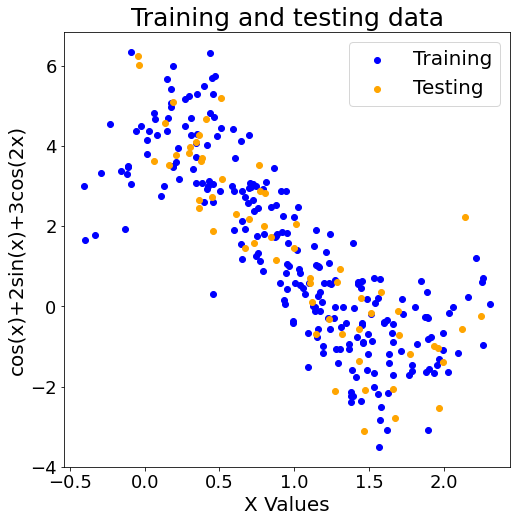

In [3]:
# Split the dataset into 80% for training and 20% for testing
x = x.reshape((x.size,1))
x_train,x_test,y_train,y_test = train_test_split(x, y, train_size=0.8, shuffle=True)

# Plot the training and testing dataset
fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(x_train, y_train, color='blue', label='Training')
ax.scatter(x_test, y_test, color='orange', label='Testing')
ax.set_xlabel('X Values',fontsize=20)
ax.set_ylabel('cos(x)+2sin(x)+3cos(2x)',fontsize=20)
ax.set_title('Training and testing data',fontsize=25)
plt.legend(fontsize=20)
plt.show()

# Create the polynomial features for a large degree for the polynomials
degree  = 1
#X_train = PolynomialFeatures(degree).fit_transform(x_train)
#X_test  = PolynomialFeatures(degree).fit_transform(x_test)
X_train = x_train
X_test = x_test

### Train Decision Tree Regression Model

In [4]:
# Fitting Decision Tree Regression to the dataset
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

# Regressor score is the coefficient of determination of the prediction
print('Training score =', np.round(regressor.score(X_train,y_train),3))
print('Testing  score =', np.round(regressor.score(X_test,y_test),3))

y_train_pred = regressor.predict(X_train)
training_mse = mean_squared_error(y_train, y_train_pred)
y_test_pred = regressor.predict(X_test)
testing_mse = mean_squared_error(y_test, y_test_pred)
    
print('Training RMSE = ', np.round(np.sqrt(training_mse),3))
print('Testing  RMSE = ', np.round(np.sqrt(testing_mse),3))

Training score = 1.0
Testing  score = 0.681
Training RMSE =  0.0
Testing  RMSE =  1.321


We get a perfect high score on the training data and a zero RMSE but only a moderately high score on the testing data and a sizable RMSE. This demonstrate extreme overfitting. Let us visualize the model and data to see the results.

### Visualization of Model Performance

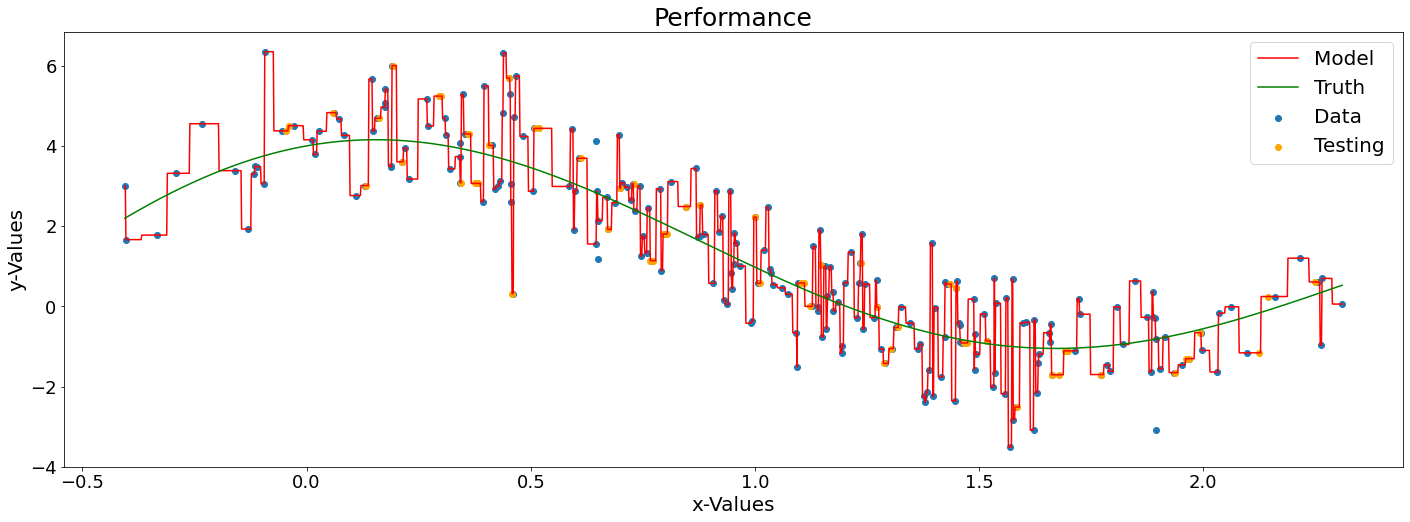

In [5]:
# Calculate results for decision tree regression
x_model = np.linspace(np.min(x), np.max(x), 2000)
X_model = x_model.reshape((x_model.size,1))
y_model_pred = regressor.predict(X_model)
y_truth = np.cos(x_model)+2*np.sin(x_model)+3*np.cos(x_model*2)

# Plot the whole dataset
fig,ax=plt.subplots(figsize=(24,8))
ax.scatter(x_train, y_train, label='Data')
ax.scatter(x_test, y_test_pred, color='orange', label='Testing')
ax.plot(x_model, y_model_pred, color='red', label='Model')
ax.plot(x_model, y_truth, color='green', label='Truth')
ax.set_xlabel('x-Values', fontsize=20)
ax.set_ylabel('y-Values', fontsize=20)
ax.set_title('Performance', fontsize=25)
ax.legend(loc='upper right', fontsize=20)
plt.show()

This plot demonstrates an important issues with decision tree regression. The resulting model is **piecewise constant**.

We also observe that there is a strong tendency to overfit. In fact,the model has **memorized all the training data**.

Let's check the predicted $y$ and true $y$ values using a scatter plot.

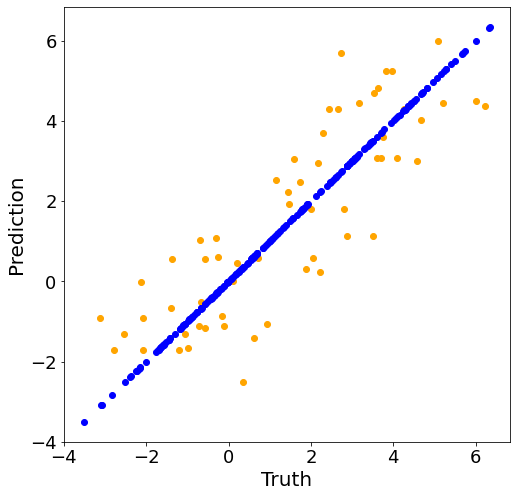

In [6]:
fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(y_test, y_test_pred, color="orange")
ax.scatter(y_train, y_train_pred, color="blue")
ax.set_xlabel('Truth', fontsize=20)
ax.set_ylabel('Prediction', fontsize=20)
plt.show()

### Hyperparameter Optimization with Cross-Validation

To address this extreme overfitting, we must optimize the hyperparameters in the decision tree regression.

Here are some of the hyperparameters for decision trees:

1. We can select gini or impurity using the `criterion` parameter. The default value is gini.

2. When the algorithm performs a split, the main goal is to decrease impurity as much as possible. The more the impurity decreases, the more informative power that split gains. As the tree gets deeper, the amount of impurity decrease becomes lower. We can use this to prevent the tree from doing further splits. The hyperparameter for this task is `min_impurity_decrease`. Its default is zero. Try changing it to see the difference.

3. If the algorithm keeps splitting nodes, the model will probably be overfit. The `min_samples_split` parameter can be used to control the tree based on impurity values. It sets a threshold on gini. Try setting it to 0.3, so a node needs to have a gini value that is more then 0.3 to be further split.

4. Another hyperparameter to control the depth of a tree is `max_depth`. It does not make any calculations regarding impurity or sample ratio. The model stops splitting when max_depth is reached. Note that `max_depth` is less flexible compared to min_impurity_decrease.

5. Another hyperparameter is `min_samples_leaf`. It indicates the minimum number of samples required to be at a leaf node.

6. We can also limit the number of leaf nodes using `max_leaf_nodes` parameter which grows the tree in best-first fashion until max_leaf_nodes reached. The best split is decided based on impurity decrease.

7. Another important hyperparameter of decision trees is `max_features` which is the number of features to consider when looking for the best split. If not specified, the model considers all of the features. There is only 1 feature in our dataset.

In cell `[4]` above, set the hyperparameter:

`regressor = DecisionTreeRegressor(hyperparameter = value)`



### Grid Search for Optimal Hyperparameters

Instead of optimizing hyperparameters one by one, we will use a grid search for the optimization of some of the hyperparameters of the decision tree model with cross-validation. The optimal values of hyperparameters depend on each other. The grid search varies all the parameters together, which ensures that we obtain a somewhat optimal model.

In [7]:
# List possible hyperparameters
regressor.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [8]:
# Grid search cross-validation
# Hyper parameters range intialization for tuning
parameters={"min_impurity_decrease" : [0, 0.05, 0.1, 0.2],
            "min_samples_split" : [0.05, 0.1, 0.2],
            "max_depth" : [2, 3, 4, 5],
            "min_samples_leaf":[1, 2, 3, 4, 5],
            "max_leaf_nodes":[None, 2, 4, 8, 12]}

In [9]:
grid_search = GridSearchCV(regressor,param_grid=parameters,
                            scoring='neg_mean_squared_error',cv=3,verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_leaf_nodes': [None, 2, 4, 8, 12],
                         'min_impurity_decrease': [0, 0.05, 0.1, 0.2],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [0.05, 0.1, 0.2]},
             scoring='neg_mean_squared_error', verbose=1)

In [10]:
# Optimial hyperparameters 
tuned_parameters = grid_search.best_params_
print(tuned_parameters)

{'max_depth': 3, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.05, 'min_samples_leaf': 1, 'min_samples_split': 0.05}


In [11]:
tuned_regressor = DecisionTreeRegressor(**tuned_parameters)
tuned_regressor.fit(X_train, y_train)

print('Training score =', np.round(tuned_regressor.score(X_train,y_train),3))
print('Testing  score =', np.round(tuned_regressor.score(X_test,y_test),3))

y_train_pred = tuned_regressor.predict(X_train)
training_mse = mean_squared_error(y_train, y_train_pred)
y_test_pred = tuned_regressor.predict(X_test)
testing_mse = mean_squared_error(y_test, y_test_pred)
    
print('Training RMSE = ', np.round(np.sqrt(training_mse),3))
print('Testing  RMSE = ', np.round(np.sqrt(testing_mse),3))

Training score = 0.801
Testing  score = 0.763
Training RMSE =  0.997
Testing  RMSE =  1.137


The tuned model does significantly better.
- It predicts similar training and testing errors.
- The testing error is significantly reduced compared to the unoptimized model.

### Visualization of Model Performance

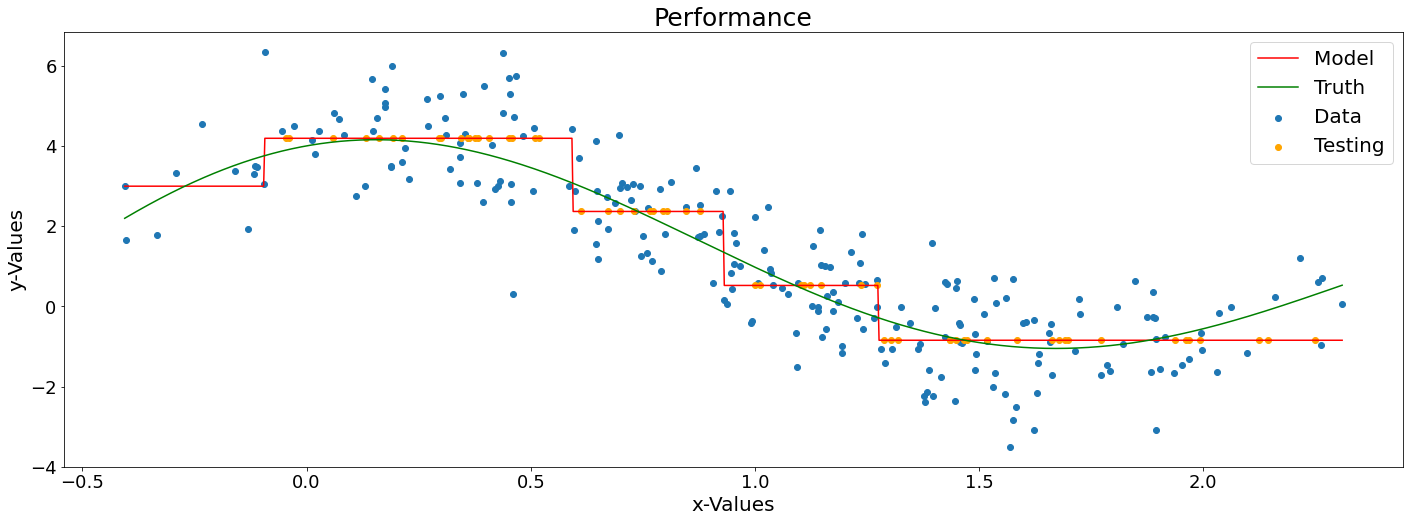

In [12]:
# Calculate optimal decision tree regression
x_model = np.linspace(np.min(x), np.max(x), 1000)
X_model = x_model.reshape((x_model.size,1))
y_model_pred = tuned_regressor.predict(X_model)
y_truth = np.cos(x_model)+2*np.sin(x_model)+3*np.cos(x_model*2)

# Plot the whole dataset
fig,ax=plt.subplots(figsize=(24,8))
ax.scatter(x_train, y_train, label='Data')
ax.scatter(x_test, y_test_pred, color='orange', label='Testing')
ax.plot(x_model, y_model_pred, color='red', label='Model')
ax.plot(x_model, y_truth, color='green', label='Truth')
ax.set_xlabel('x-Values', fontsize=20)
ax.set_ylabel('y-Values', fontsize=20)
ax.set_title('Performance', fontsize=25)
ax.legend(loc='upper right', fontsize=20)
plt.show()

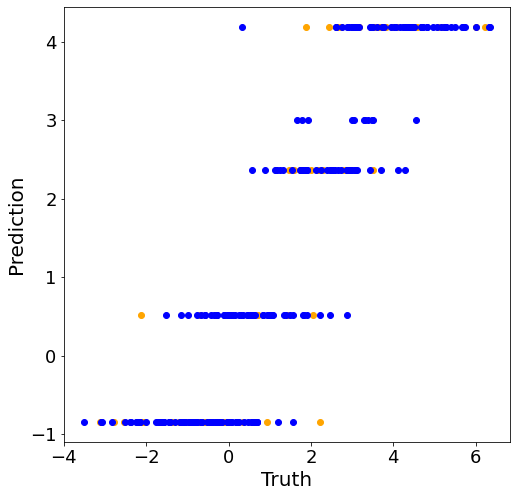

In [13]:
fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(y_test, y_test_pred, color="orange")
ax.scatter(y_train, y_train_pred, color="blue")
ax.set_xlabel('Truth', fontsize=20)
ax.set_ylabel('Prediction', fontsize=20)
plt.show()

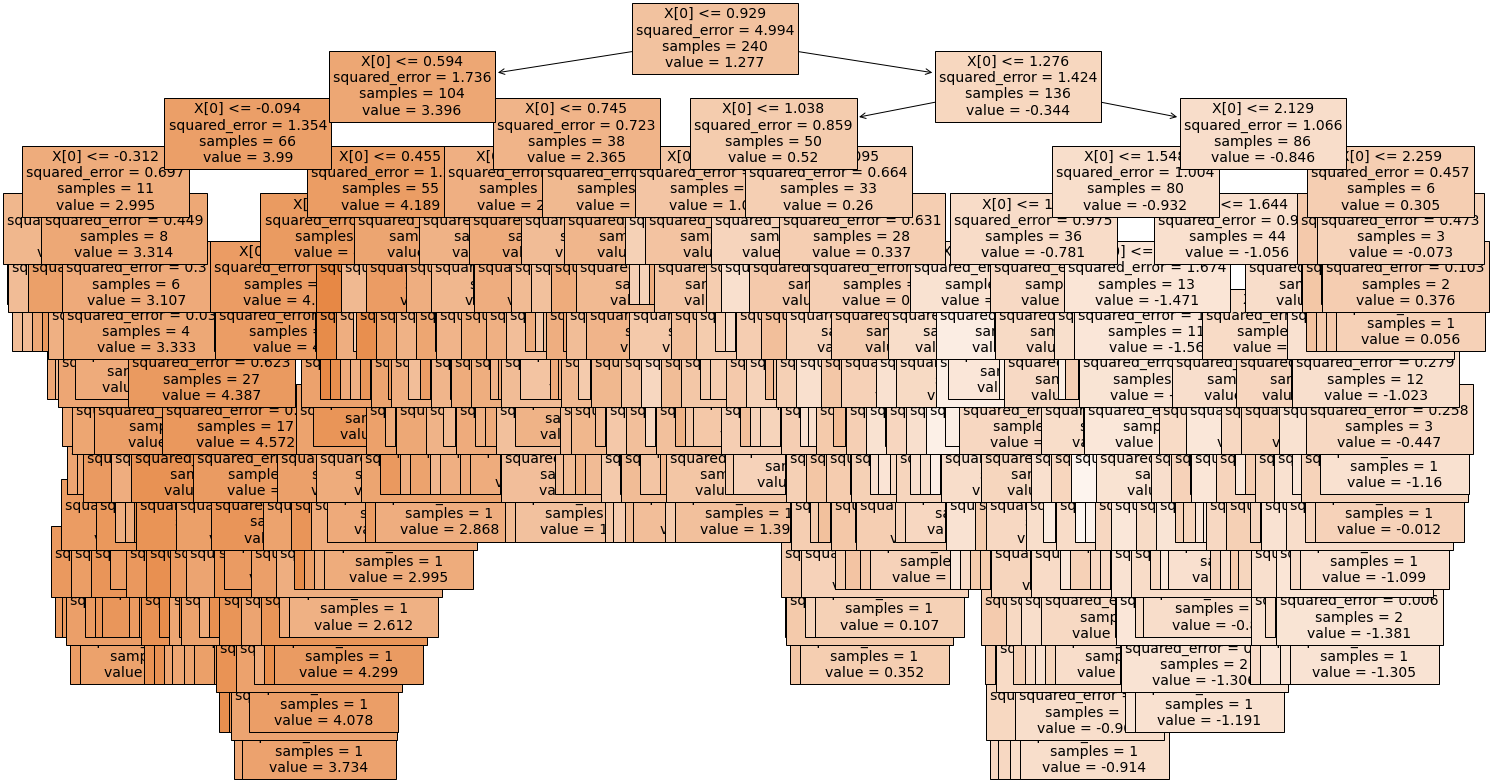

In [14]:
plt.figure(figsize=(24,14))
plot_tree(regressor, filled=True, fontsize=14)
plt.show()

Well, considering how few parameters polynomial regression required, clearly decision trees are not optimal for fitting simple low-dimensional functions. In fact this decision tree map looks somewhat like a flipped Australia.

<img src="https://www.nationsonline.org/maps/australia-map-1400px.jpg" alt="Map of Australia" align="center" style="width: 600px;float: center;"/>

### Summary

Decision trees are white box machine learning algorithms that are useful for classification and regression. Some of the advantages of decision trees are:

- Easy to understand and interpret
- Can handle both numerical and categorical data
- Requires little or no preprocessing such as normalization or dummy encoding

On the downside, decision trees are prone to overfitting. They can easily become overly complex, which prevents them from generalizing well. It is therfore essential to optimize the hyperparameters for decision trees using crossvalidation.